In [1]:
%matplotlib inline

In [2]:
!pip3 install torch torchvision torchaudio

/usr/local/lib/python3.8/dist-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/local/lib/python3.8/dist-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.



Audio Resampling
================

This tutorial shows how to use torchaudio's resampling API.


In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.12.0+cu102
0.12.0+cu102


Preparation
-----------

First, we import the modules and define the helper functions.

<div class="alert alert-info"><h4>Note</h4><p>When running this tutorial in Google Colab, install the required packages
   with the following.

   .. code::

      !pip install librosa</p></div>



In [5]:
import math
import time

import librosa
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]
        로그 스케일에서 균등한 간격으로 주파수 가져오기,
    offset is used to avoid negative infinity `log(offset + x)`.
    오프셋은 음의 무한대를 피하기 위해 사용됩니다.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2) # ln(x)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset
    # offset까지와 이후부터 max_sweep_rate를 2로 나눈 값을 더해준 값을 ln을 취해준 뒤 start, stop에 지정
    # linspace를 이용하여 균등한 간격인 1차원 텐서를 sample_rate만큼 만든다. 그리고 그 것을 e의 x승의 형태로 치환
    

def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq
     _get_log_freq에 의해 주어진 빈도를 통해 시간을 찾으십시오."""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    # sweep생성에 사용된 original sample rate가 주어지면
    # 로그 스케일 주요 주파수 값에서 x축 값을 찾습니다.
    time, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                time.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    time.append(t_max)
    freq.append(f_max)
    return time, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)
    plt.show(block=True)

Resampling Overview
-------------------

To resample an audio waveform from one freqeuncy to another, you can use
:py:func:`torchaudio.transforms.Resample` or
:py:func:`torchaudio.functional.resample`.
``transforms.Resample`` precomputes and caches the kernel used for resampling,
while ``functional.resample`` computes it on the fly, so using
``torchaudio.transforms.Resample`` will result in a speedup when resampling
multiple waveforms using the same parameters (see Benchmarking section).

Both resampling methods use `bandlimited sinc
interpolation <https://ccrma.stanford.edu/~jos/resample/>`__ to compute
signal values at arbitrary time steps. The implementation involves
convolution, so we can take advantage of GPU / multithreading for
performance improvements.\
두 리샘플링 방법 모두 대역 제한 sinc 보간 을 사용하여 임의의 시간 단계에서 신호 값을 계산합니다. 구현에는 컨볼루션이 포함되므로 성능 향상을 위해 GPU/멀티스레딩을 활용할 수 있습니다.

<div class="alert alert-info"><h4>Note</h4><p>When using resampling in multiple subprocesses, such as data loading
   with multiple worker processes, your application might create more
   threads than your system can handle efficiently.
   Setting ``torch.set_num_threads(1)`` might help in this case.</p></div>

Because a finite number of samples can only represent a finite number of
frequencies, resampling does not produce perfect results, and a variety
of parameters can be used to control for its quality and computational
speed. We demonstrate these properties through resampling a logarithmic
sine sweep, which is a sine wave that increases exponentially in
frequency over time.\
유한한 수의 샘플은 유한한 수의 주파수만 나타낼 수 있기 때문에 리샘플링은 완벽한 결과를 생성하지 않으며 다양한 매개변수를 사용하여 품질과 계산 속도를 제어할 수 있습니다.\
시간이 지남에 따라 주파수가 기하급수적으로 증가하는 로그 사인 스윕을 다시 샘플링하여 이러한 속성을 보여줍니다.

The spectrograms below show the frequency representation of the signal,
where the x-axis corresponds to the frequency of the original
waveform (in log scale), y-axis the frequency of the
plotted waveform, and color intensity the amplitude.\
아래 스펙트로그램은 신호의 주파수 표현을 보여줍니다. 여기서 x축은 원래 파형의 주파수(로그 스케일), y축은 플롯된 파형의 주파수, 색상 강도는 진폭에 해당합니다.




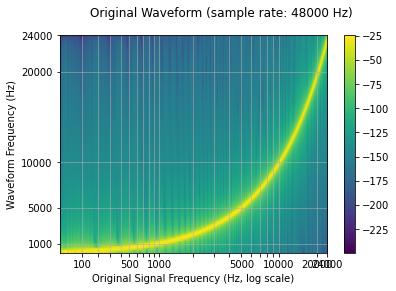

In [6]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

Now we resample (downsample) it.

We see that in the spectrogram of the resampled waveform, there is an
artifact, which was not present in the original waveform.\
리샘플링된 파형의 스펙트로그램에서 원래 파형에는 없는 인공물이 있음을 알 수 있습니다.




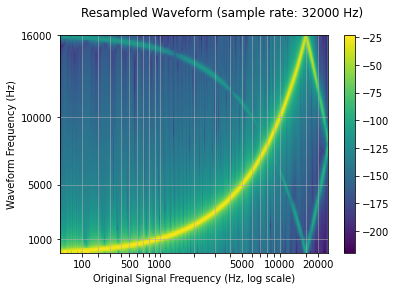

In [7]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

Controling resampling quality with parameters
---------------------------------------------

Lowpass filter width
~~~~~~~~~~~~~~~~~~~~

Because the filter used for interpolation extends infinitely, the ``lowpass_filter_width`` parameter is used to control for the width of the filter to use to window the interpolation.
보간에 사용되는 필터는 무한대로 확장되기 때문에 ``lowpass_filter_width`` 매개변수는 보간 창에 사용할 필터의 너비를 제어하는데 사용됩니다.

It is also referred to as the number of zero crossings, since the interpolation passes through zero at every time unit. 
보간은 모든 시간 단위에서 0을 통과하기 때문에 제로 크로싱의 수라고도 합니다.

Using a larger ``lowpass_filter_width`` provides a sharper, more precise filter, but is more computationally expensive.
더 큰 ``lowpass_filter_width``를 사용하면 더 선명하고 정확한 필터를 제공하지만 계산 비용이 더 많이 듭니다.




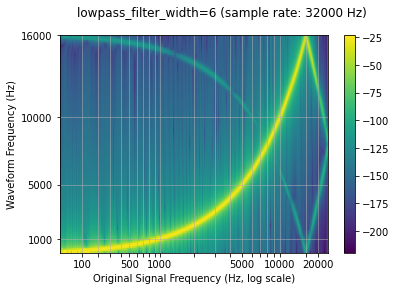

In [8]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

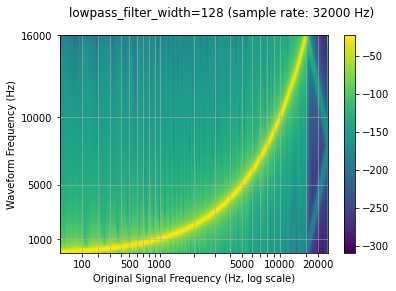

In [9]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

Rolloff
~~~~~~~

The ``rolloff`` parameter is represented as a fraction of the Nyquist frequency, which is the maximal frequency representable by a given finite sample rate. 
``rolloff`` 매개변수는 Nyquist 주파수의 일부로 표시되며, 이는 주어진 유한 샘플 속도로 표현할 수 있는 최대 주파수입니다.

``rolloff`` determines the lowpass filter cutoff and controls the degree of aliasing, which takes place when frequencies higher than the Nyquist are mapped to lower frequencies. 
``rolloff``는 the lowpass filter cutoff를 결정하고 Nyquist보다 높은 주파수가 더 낮은 주파수에 매핑될 때 발생하는 앨리어싱 정도를 제어합니다.

A lower rolloff will therefore reduce the amount of aliasing, but it will also reduce some of the higher frequencies.
따라서 rolloff가 낮을수록 앨리어싱의 양이 줄어들지만 일부 더 높은 주파수도 감소합니다.




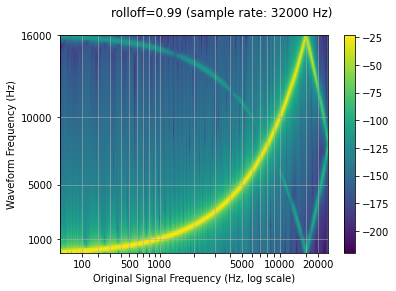

In [10]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

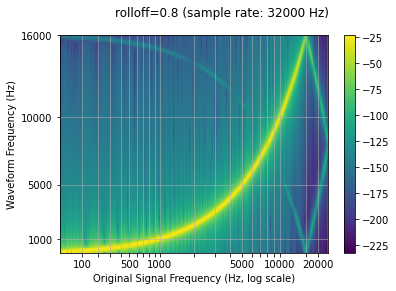

In [11]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

Window function
~~~~~~~~~~~~~~~

By default, ``torchaudio``’s resample uses the Hann window filter, which is a weighted cosine function. 
기본적으로 ``torchaudio``의 리샘플은 가중 코사인 함수인 Hann 윈도우 필터를 사용합니다.

It additionally supports the Kaiser window, which is a near optimal window function that contains an additional ``beta`` parameter that allows for the design of the smoothness of the filter and width of impulse.
또한 필터의 부드러움과 임펄스 폭의 설계를 허용하는 추가 ``베타`` 매개변수를 포함하는 최적에 가까운 창 함수인 카이저 창을 지원합니다.

This can be controlled using the ``resampling_method`` parameter.
이는 ``resampling_method`` 매개변수를 사용하여 제어할 수 있습니다.



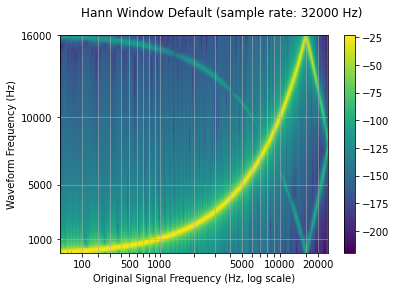

In [12]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

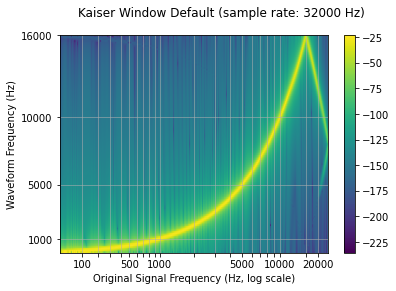

In [13]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

Comparison against librosa
--------------------------

``torchaudio``’s resample function can be used to produce results similar to
that of librosa (resampy)’s kaiser window resampling, with some noise.

``torchaudio``의 resample 기능을 사용하여 약간의 노이즈가 있지만 librosa(resampy)의 카이저 창 리샘플링과 유사한 결과를 생성할 수 있습니다.




In [14]:
sample_rate = 48000
resample_rate = 32000

kaiser_best
~~~~~~~~~~~




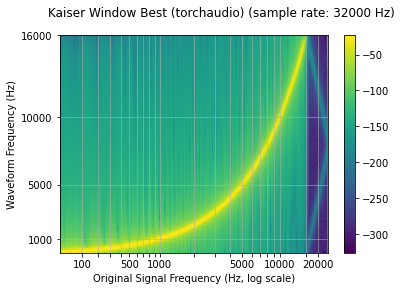

In [15]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

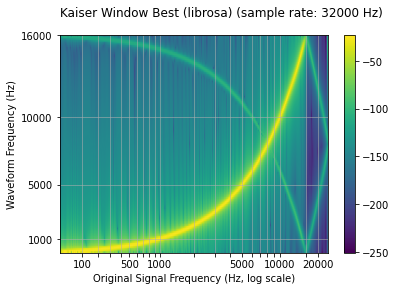

In [16]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_best")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

In [17]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

torchaudio and librosa kaiser best MSE: 2.0806901153659852e-06


kaiser_fast
~~~~~~~~~~~




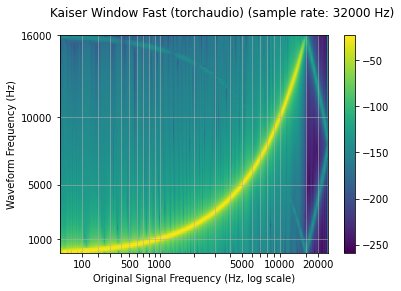

In [21]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16, # 64에서 16으로
    rolloff=0.85, # 0.9475937167399596,에서 0.85로
    resampling_method="kaiser_window",
    beta=8.555504641634386, # 14.769656459379492,에서 8.55로
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")

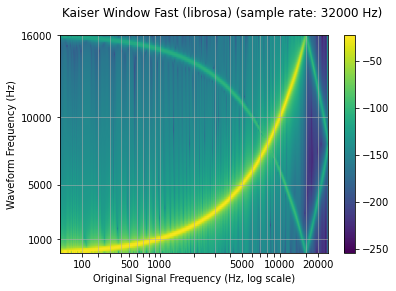

In [22]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_fast")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Fast (librosa)")

In [23]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser fast MSE:", mse)

torchaudio and librosa kaiser fast MSE: 2.5200744248601034e-05


Performance Benchmarking
------------------------

Below are benchmarks for downsampling and upsampling waveforms between
two pairs of sampling rates.\
다음은 두 쌍의 샘플링 속도 간의 다운샘플링 및 업샘플링 파형에 대한 벤치마크입니다.

We demonstrate the performance implications
that the ``lowpass_filter_wdith``, window type, and sample rates can
have. \
lowpass_filter_wdith, window type 및 sample rates가 가질 수 있는 성능 영향을 보여줍니다.

Additionally, we provide a comparison against ``librosa`` ’s
``kaiser_best`` and ``kaiser_fast`` using their corresponding parameters
in ``torchaudio``.\
또한 ``torchaudio``의 해당 매개변수를 사용하여 ``librosa``의 ``kaiser_best`` 및 ``kaiser_fast``에 대한 비교를 제공합니다.

To elaborate on the results:
결과를 자세히 설명하려면 다음을 수행합니다.

- a larger ``lowpass_filter_width`` results in a larger resampling kernel,
  and therefore increases computation time for both the kernel computation
  and convolution\
  더 큰 lowpass_filter_width는 더 큰 리샘플링 커널을 생성하므로 커널 계산과 컨볼루션 모두에 대한 계산 시간이 늘어납니다.
- using ``kaiser_window`` results in longer computation times than the default
  ``sinc_interpolation`` because it is more complex to compute the intermediate
  window values - a large GCD between the sample and resample rate will result
  in a simplification that allows for a smaller kernel and faster kernel computation.\
 ``kaiser window``를 사용하면 중간 window values을 계산하는 것이 더 복잡하기 때문에 기본 ''sinc interpolation''보다 계산 시간이 더 길어집니 - 샘플과 리샘플링 속도 사이의 큰 GCD(최대공약수)는 더 작은 커널과 더 빠른 커널 계산을 허용하는 단순화를 가져옵니다.




In [25]:
def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interpolation",
    beta=None,
    librosa_type=None,
    iters=5,
):
    if method == "functional":
        begin = time.monotonic() # 뒤로 갈 수 없는 시계의 값
        for _ in range(iters):
            F.resample(
                waveform,
                sample_rate,
                resample_rate,
                lowpass_filter_width=lowpass_filter_width,
                rolloff=rolloff,
                resampling_method=resampling_method,
            )
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "transforms":
        resampler = T.Resample(
            sample_rate,
            resample_rate,
            lowpass_filter_width=lowpass_filter_width,
            rolloff=rolloff,
            resampling_method=resampling_method,
            dtype=waveform.dtype,
        )
        begin = time.monotonic()
        for _ in range(iters):
            resampler(waveform)
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "librosa":
        waveform_np = waveform.squeeze().numpy()
        begin = time.monotonic()
        for _ in range(iters):
            librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=resample_rate, res_type=librosa_type)
        elapsed = time.monotonic() - begin
        return elapsed / iters

In [26]:
configs = {
    "downsample (48 -> 44.1 kHz)": [48000, 44100],
    "downsample (16 -> 8 kHz)": [16000, 8000],
    "upsample (44.1 -> 48 kHz)": [44100, 48000],
    "upsample (8 -> 16 kHz)": [8000, 16000],
}

for label in configs:
    times, rows = [], []
    sample_rate = configs[label][0]
    resample_rate = configs[label][1]
    waveform = get_sine_sweep(sample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_best")
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
    rows.append("kaiser_best")

    # kaiser fast
    lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_fast")
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    df.columns = pd.MultiIndex.from_product([[f"{label} time (ms)"], df.columns])

    print(f"torchaudio: {torchaudio.__version__}")
    print(f"librosa: {librosa.__version__}")
    display(df.round(2))

torchaudio: 0.12.0+cu102
librosa: 0.6.3


downsample (48 -> 44.1 kHz) time (ms)                      
                                              librosa functional transforms
sinc (width 64)                                   NaN      13.00       0.90
sinc (width 16)                                   NaN      11.97       0.58
kaiser_best                                     23.86      18.55       1.05
kaiser_fast                                      6.45      16.90       0.64

torchaudio: 0.12.0+cu102
librosa: 0.6.3


downsample (16 -> 8 kHz) time (ms)                      
                                           librosa functional transforms
sinc (width 64)                                NaN       4.10       2.95
sinc (width 16)                                NaN       1.03       0.87
kaiser_best                                   8.44       4.18       2.99
kaiser_fast                                   2.89       1.67       1.17

torchaudio: 0.12.0+cu102
librosa: 0.6.3


upsample (44.1 -> 48 kHz) time (ms)                      
                                            librosa functional transforms
sinc (width 64)                                 NaN      13.58       0.92
sinc (width 16)                                 NaN      13.51       0.72
kaiser_best                                   26.12      20.09       1.11
kaiser_fast                                    6.45      18.13       0.79

torchaudio: 0.12.0+cu102
librosa: 0.6.3


upsample (8 -> 16 kHz) time (ms)                      
                                         librosa functional transforms
sinc (width 64)                              NaN       1.68       1.40
sinc (width 16)                              NaN       0.60       0.40
kaiser_best                                 8.58       1.66       1.34
kaiser_fast                                 2.83       0.74       0.47